## What You'll Learn

In this notebook, you'll learn how to:

- Set up a LangGraph workflow  
- Define state and nodes for email processing  
- Create conditional branching in a graph  
- Connect an LLM for classification and content generation  
- Visualize the workflow graph  
- Execute the workflow with example data  

In [1]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

You should consider upgrading via the '/Users/ron/Documents/github/myenv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Setting Up Our Environment

In [3]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import os
from dotenv import load_dotenv

In [22]:
# Load the .env file
load_dotenv()

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [9]:
# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Define Our State

In LangGraph, State is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:

- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [11]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]

## Step 2: Define Our Nodes

In [13]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else:
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}


def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }


def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}


# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


In [14]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)  # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email)  # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam)  #same logic
email_graph.add_node("drafting_response", drafting_response)  #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # same logic

In [15]:
# Add edges
email_graph.add_edge(START, "read_email")  # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email")  # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email",  # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam",  # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response"  # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)  # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)  # after notifyinf Me wayne, we can end  too


## Step 4: Create the StateGraph and Define Edges

In [17]:
# Compile the graph
compiled_graph = email_graph.compile()

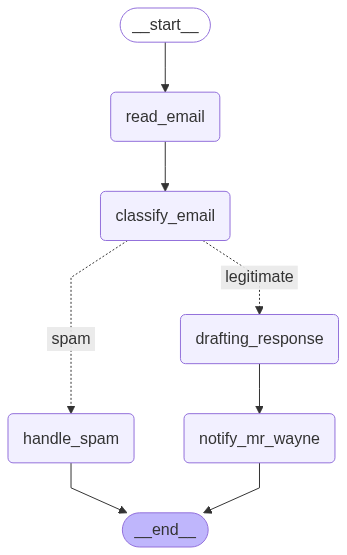

In [18]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [19]:
# Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Mr. Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne values privacy and discretion, and any matters of concern will be addressed with the utmost seriousness.

Kind regards,

Alfred Pennyworth  
On behalf of Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


## Step 5: Inspecting Our Mail Sorting Agent with Langfuse

As Alfred fine-tunes the Main Sorting Agent, he's growing weary of debugging its runs. Agents, by nature, are unpredictable and difficult to inspect. But since he aims to build the ultimate Spam Detection Agent and deploy it in production, he needs robust traceability for future monitoring and analysis.

To do this, Alfred can use an observability tool such as [Langfuse](https://langfuse.com) to trace and monitor the inner steps of the agent.

First, we need to install the necessary dependencies:

In [20]:
%pip install -q langfuse

You should consider upgrading via the '/Users/ron/Documents/github/myenv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com"

In [26]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [27]:
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Mr. Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne is currently unavailable, but rest assured, your concerns will be addressed in due course.

Kind regards,

Alfred Pennyworth  
Wayne Manor Estate


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


## Traces ##

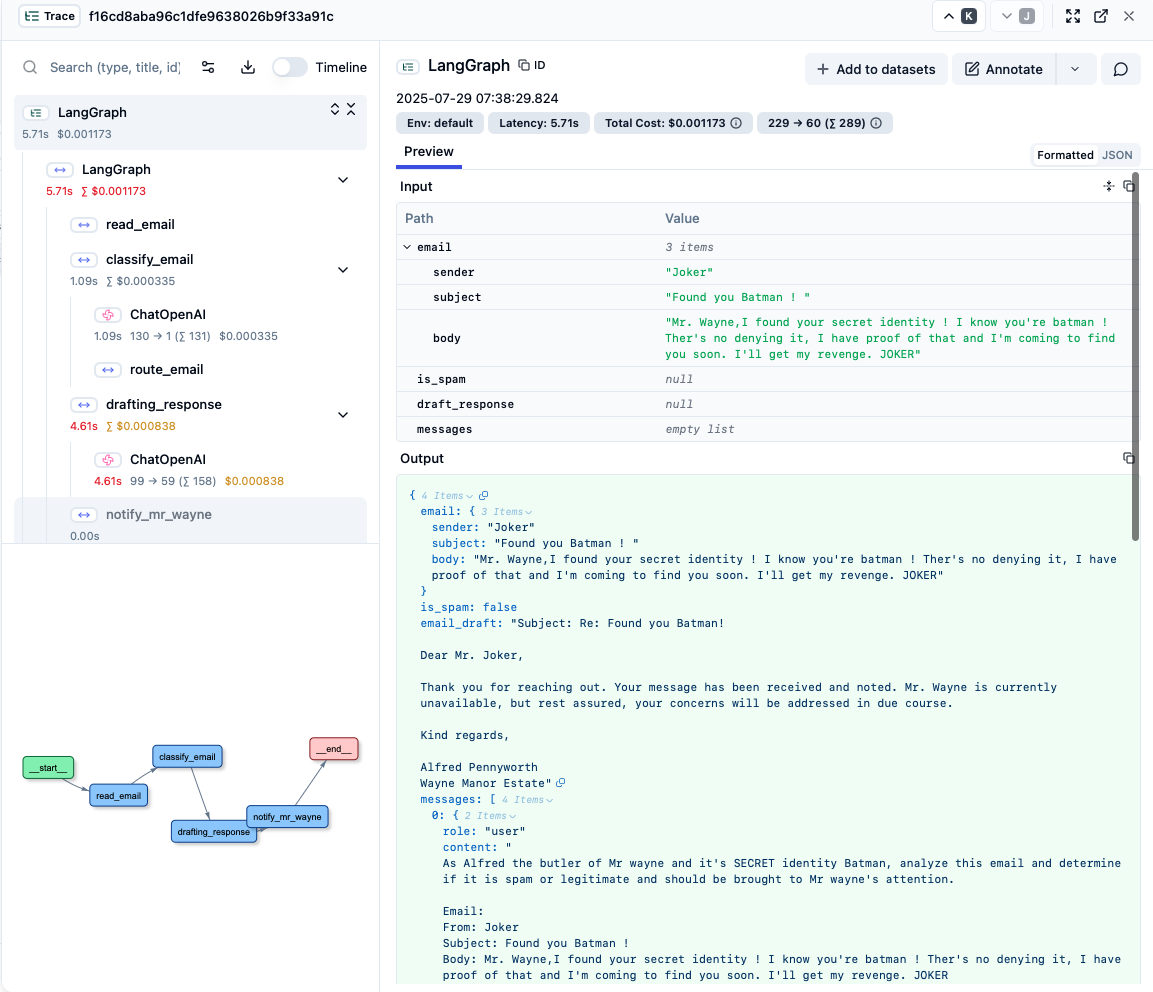

In [35]:
from IPython.display import Image, display

display(Image(filename='/Users/ron/Documents/github/AI_Agents_HF/LangGraph/Joker_1.png'))


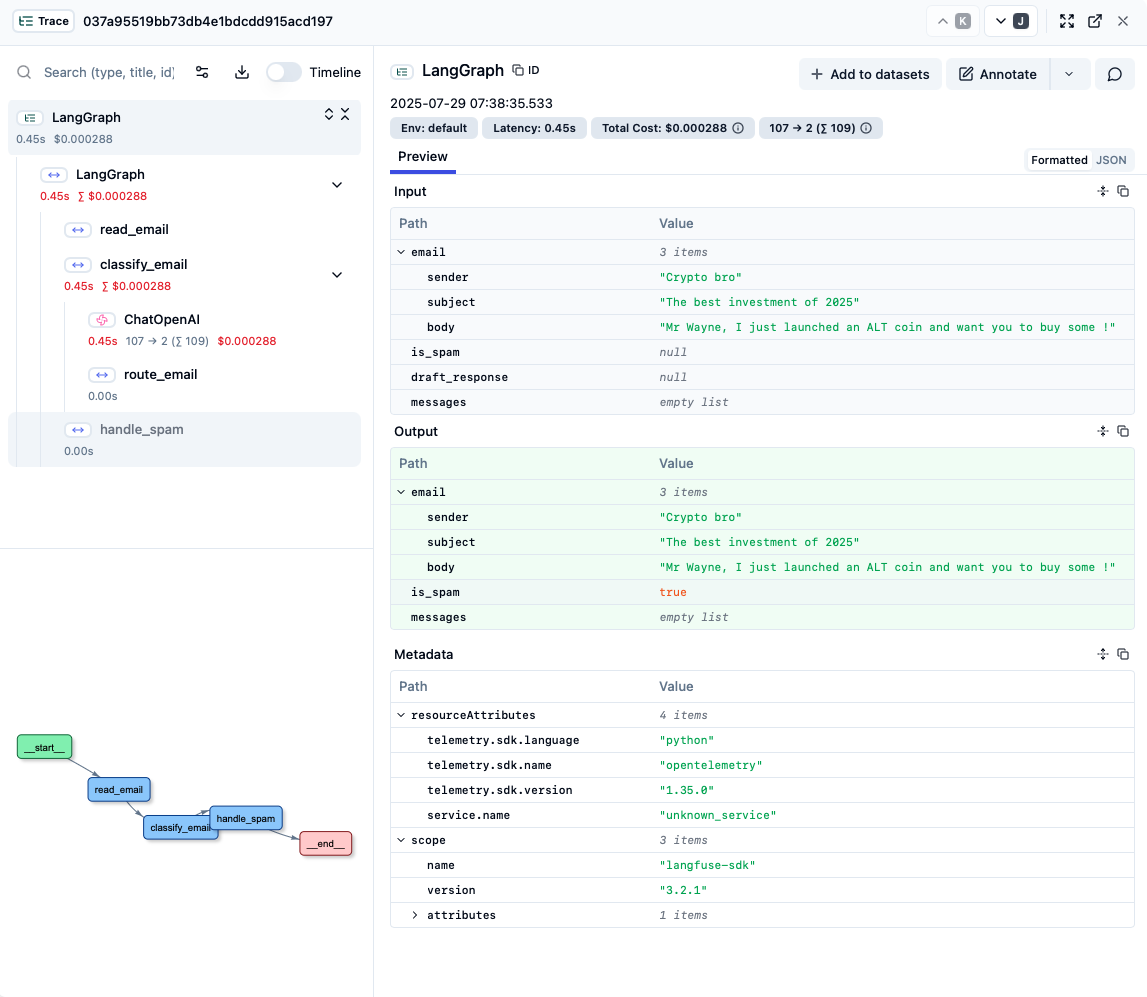

In [37]:
display(Image(filename='/Users/ron/Documents/github/AI_Agents_HF/LangGraph/cryptobro.png'))